# Project 4: Advanced Lane Finding

This project aims to develop a pipeline which allows for the detection lane lines in a video. In contrast to the similar project _Finding Lane Lines on the Road_ this project makes use of a couple of new methods which allow to detect lane lines more robustly. Our pipeline consists of the following steps
* camera calibration
* color and gradient thresholds for lane line selection
* perspective transformation
* lane line fitting
* inverse transformation

Each of these steps is discussed in detail in the next sections.

## 1. Camera Calibration

Modern cameras suffer from distortion effects i.e. objects appear to have a different sizes and shapes than they actual have. Fortunatley cameras can be easily calibrated. Calibration removes most of the distortion effects. 

For a reliable calibration a set of approximately 20 images of the same object is needed. This object needs to have a number of well defined points with known relative distances. A good choice is a chess board. Its corner points can be easily detected automatically and the distance between them is always the same.  

Using the functionality of opencv one can compute distortion coefficients and the camera matrix based the location of these corner points.

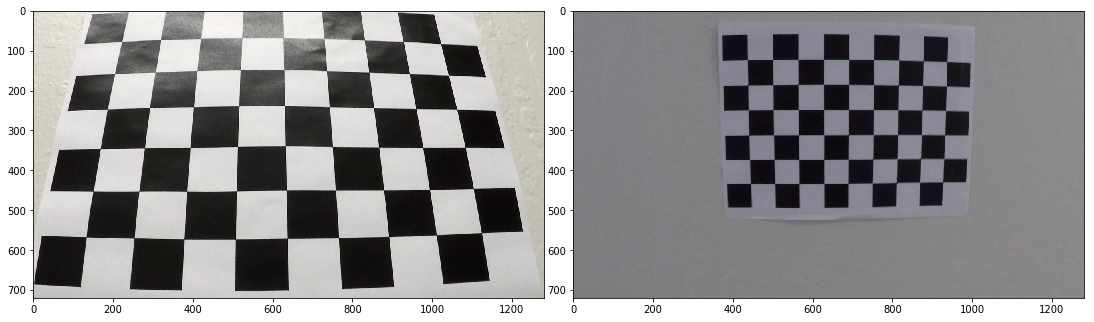

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

def display_images(images, figsize = (15, 10), title=None, fontsize=20):
    "Display images in two columns. Choose gray-scale colorbar if image is two-dimensional."
    ncols = 2
    nrows = np.ceil(len(images)/2)
    
    fig = plt.figure(figsize = figsize)
    for i, image in enumerate(images, start = 1):
        ax = fig.add_subplot(nrows, ncols, i)
        if title is not None:
            ax.set_title(title[i-1], fontsize=fontsize)
        plt.imshow(image) if len(image.shape) == 3 else plt.imshow(image, cmap='gray')
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
# load images for camera calibration
images_cal = [mpimg.imread(image) for image in glob.glob("camera_cal/*.jpg")]

display_images(images_cal[:2])

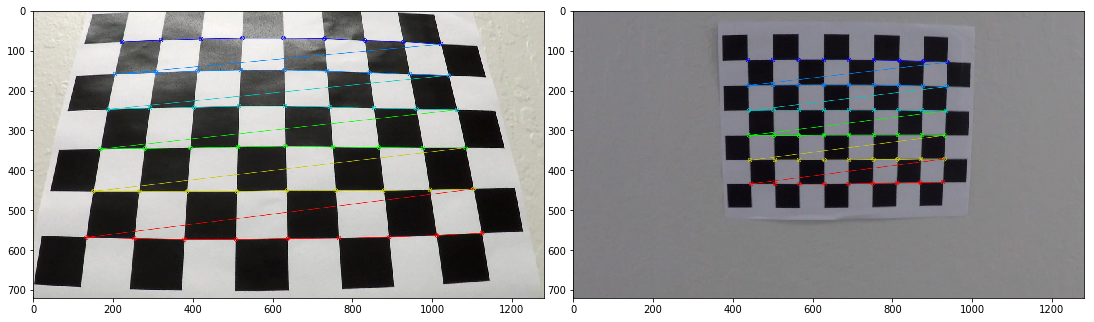

In [2]:
def calibration_points(images_cal, n_rows, n_cols):
    """Determine object and image points for camera calibration.
    
    Assumes that images_cal is a list of images of a chessboard taken with the same 
    camera but from different perspectives. Algorithm detects corners and uses them as 
    images points.
    
    Args:
        images_cal -- Images of a chessboard
        n_rows     -- number of rows
        n_cols     -- number of columns
    """
    # prepare object points: (0,0,0), (1,0,0), ...
    objp = np.zeros((n_rows*n_cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:n_rows,0:n_cols].T.reshape(-1,2) # python trick
    objpoints = [] # 3D real-world points    
    imgpoints = [] # 2D image points
    images_corner = [] 
    # iterate over images and determine object and image points 
    for image in images_cal:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (n_rows, n_cols), None)
        # if pattern was successfully found in image add object and image points
        if ret:
            objpoints.append(objp)
            # refine corners (optional)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
            # create image with found corners drawn onto it for assessing the quality of the method
            img = np.copy(image)       
            images_corner.append(cv2.drawChessboardCorners(img, (n_rows,n_cols), corners, ret))
    return objpoints, imgpoints, images_corner   
    
    
# determine object and image points
objpoints, imgpoints, images_corner = calibration_points(images_cal, 9, 6)

# check if corners where detected correctly
display_images(images_corner[:2])

In [3]:
def calibrate_camera(objpoints, imgpoints, shape):
    """Calibrate camera using object and image points and return camera matrix and distortion coefficients."""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return mtx, dist

def undistort(img, mtx, dist):
    """Undistort image.
    
    Args:
        img  -- distorted image
        mtx  -- camera matrix
        dist -- distortion coefficients
    """
    return cv2.undistort(img, mtx, dist, None, mtx)


height, width, _ = images_cal[0].shape
mtx, dist = calibrate_camera(objpoints, imgpoints, (width, height))

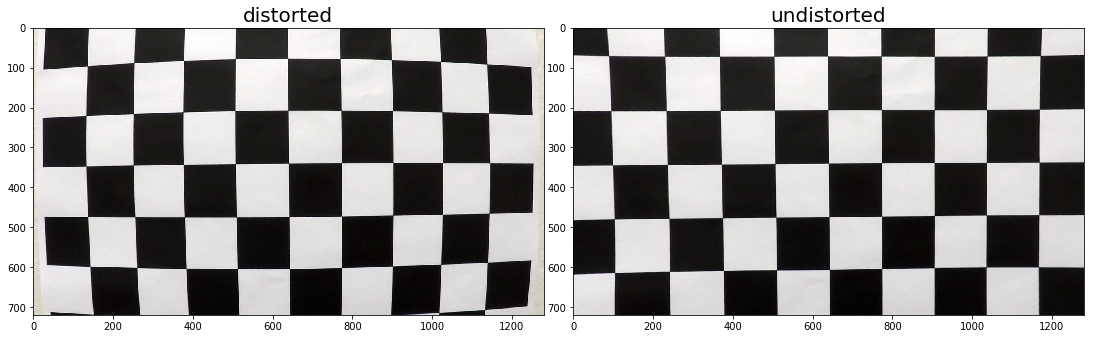

In [4]:
images_cal_undis = [undistort(image, mtx, dist) for image in images_cal]

display_images([images_cal[6], images_cal_undis[6]], title=['distorted', 'undistorted'], fontsize=20) 

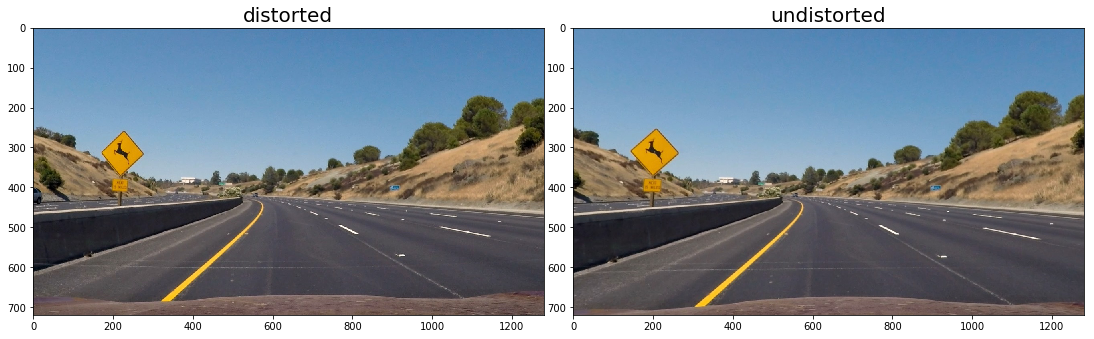

In [5]:
# read test images
images_orig = [mpimg.imread(image) for image in glob.glob("test_images/*.jpg")]
   
images_undis = [undistort(image, mtx, dist) for image in images_orig]

display_images([images_orig[0], images_undis[0]], title=['distorted', 'undistorted'], fontsize=20) 

## 2. Color and Gradient Threshold

The original images contain many objects and structures which are not related to lane lines. For conducting a successful fit of a polynom to potential lane line pixels one has to suppress unrelated pixels as much as possible. The course presented various methods how this can be achieved e.g. through thresholds on properties of the gradient. We don't use properties of the gradient and restrict ourselves to a simple color and region selection. 

Since  lane lines are located in approximately the same region of the image one can choose a polygon of fixed dimensions to select the region of interest. Lane lines are typically either yellow or white. We transform the image from RGB colorspace to HLS colorspace and select white and yellow colors. This filter is more robust than conducting the selection process directly in RGB colorspace. 

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    """Zero all pixels with a gradient smaller than a given threshold.
    
    Args:
        img          -- original image
        orient       -- direction of the gradient
        sobel_kernel -- size of the kernel
        thresh       -- lower and upper threshold
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)   
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)         
    magn = np.absolute(sobel)
    magn = np.uint(255*magn/np.max(magn))
    binary_output = np.zeros_like(magn, dtype=np.uint8)
    binary_output[(magn > thresh[0]) & (magn < thresh[1])] = 1   
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255)):   
    """Zero all pixels with a magnitude of the gradient smaller than a given threshold.
    
    Args:
        img          -- original image
        sobel_kernel -- size of the kernel
        thresh       -- lower and upper threshold
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)   
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)         
    magn = np.sqrt(sobelx**2 + sobely**2)    
    magn = np.uint(255*magn/np.max(magn))
    binary_output = np.zeros_like(magn, dtype=np.uint8)
    binary_output[(magn > mag_thresh[0]) & (magn < mag_thresh[1])] = 1
    return binary_output   

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Zero all pixels with direction of the gradient not in range defined by thresh.
    
    Args:
        img          -- original image
        sobel_kernel -- size of the kernel
        thresh       -- lower and upper threshold of direction (in radiants)
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx)) 
    binary_output = np.zeros_like(absgraddir, dtype=np.uint8)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1    
    return binary_output    

def region_of_interest(img):
    """Zero all pixels expect pixels in region defined by vertices."""
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        ignore_mask_color = (255,) * img.shape[2] 
    else:
        ignore_mask_color = 255
    bottom_left = (0.10, 0.97)
    top_left = (0.41, 0.64)
    top_right = (0.59, 0.65)
    bottom_right = (0.96, 0.96)
    xdim, ydim  = img.shape
    bl_y, bl_x = bottom_left
    tl_y, tl_x = top_left
    tr_y, tr_x = top_right
    br_y, br_x = bottom_right
    v1 = int(bl_y*ydim), int(bl_x*xdim)
    v2 = int(tl_y*ydim), int(tl_x*xdim)
    v3 = int(tr_y*ydim), int(tr_x*xdim)
    v4 = int(br_y*ydim), int(br_x*xdim)
    vertices = np.array([[v1, v2, v3, v4]])   
    # set pixel intensities to ignore_mask_color inside region defined by vertices
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # zero all pixel outside of region defined by vertices
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def select_white_yellow(image):
    """Select white and yellow lane lines."""
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white color mask
    #lower = np.uint8([200, 200, 200])
    #upper = np.uint8([255, 255, 255])
    #white_mask_1 = cv2.inRange(image, lower, upper)
    lower = np.uint8([0,   200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask_2 = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 60, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine  masks
    mask = cv2.bitwise_or(white_mask_2, yellow_mask)
    color_binary = np.zeros_like(mask)
    color_binary[mask==255] = 1
    return color_binary

def threshold(img):
    """Apply color and region selection to img and return a binary image."""
    color_binary = select_white_yellow(img)
    return region_of_interest(color_binary)


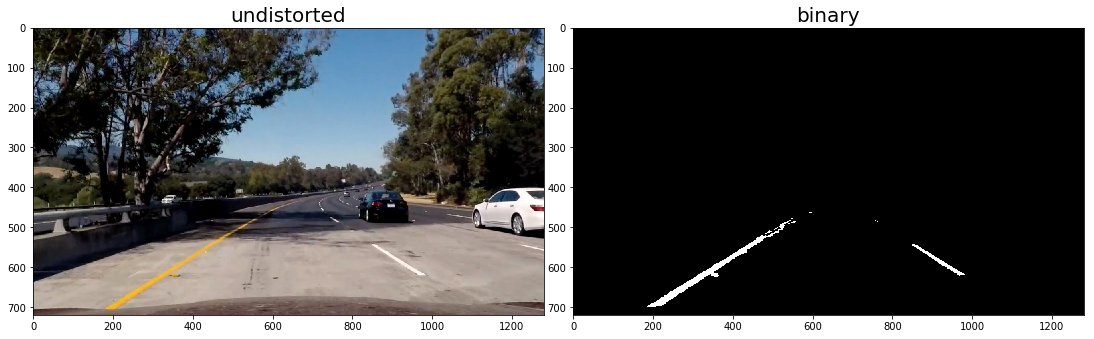

In [7]:
images_thresh = [threshold(image) for image in images_undis]

display_images([images_undis[3], images_thresh[3]], title=['undistorted', 'binary'], fontsize=20)

## 3. Perspective Transformation

In order to facilitate a reliable fit of a polynom to lane line pixels we need to perform a perspective transformation. This is also requiered if we want to determine the curvature of the lane lines. The most appropriate perspective is the birds-eye perspective. In this perspective straight lane lines should also appear straight in the image.

The transformation matrix can be inferred from a set of four points in the original image (source points) and a set of four points in the transformed image (destination points). The transformation matrix maps the four source points to the four destination points. 

We need one original image with straight lane lines and choose the four source points such that they are directly on top of the lane line markings. The destination points have to form a rectangle.

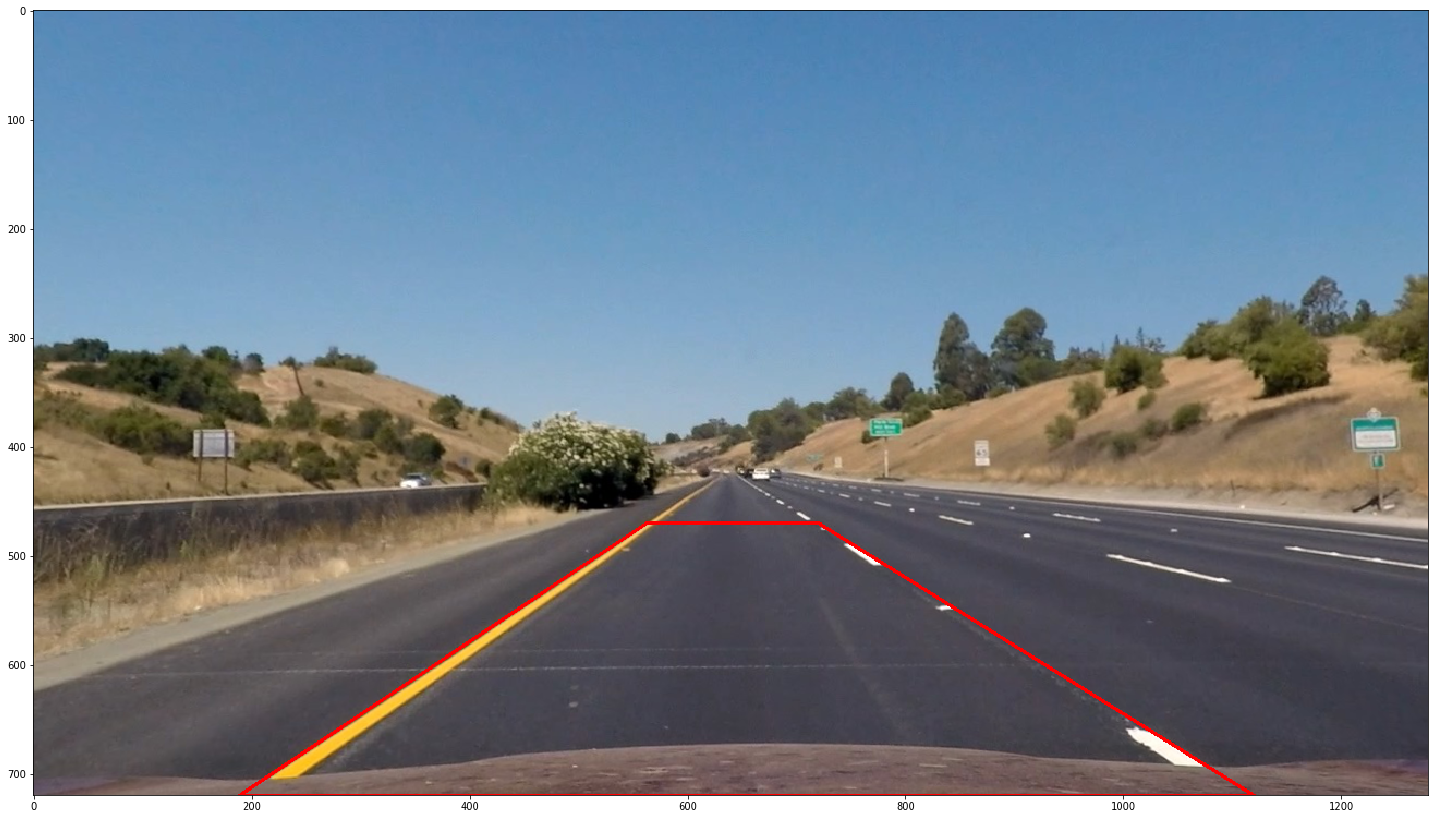

In [8]:
# read images with straight lane lines 
images_straight = [mpimg.imread(image) for image in glob.glob("test_images/straight_lines*.jpg")]

# undistort images of straight lane lines
images_undis_straight = [undistort(image, mtx, dist) for image in images_straight]

# draw image with rectangle
img_poly = np.copy(images_undis_straight[0])
src = np.array([[1120, 720], [189, 720], [563, 470], [720, 470]], dtype=np.int32)
src = src.reshape((-1,1,2))
cv2.polylines(img_poly, [src], True, (255,0,0), thickness=2)

fig = plt.figure(figsize = (25, 20))
plt.imshow(img_poly);

In [9]:
 def unwarp_matrix():
    """Return transformation matrix for birds-eye view and its inverse."""
    src = np.array([[1110, 720],  # bottom right 
                    [189, 720],   # bottom left
                    [563, 470],   # top left
                    [720, 470]],  # top right 
                    dtype=np.float32)
    dst = np.array([[920, 720], [320,720], [320, 1], [920, 1]], dtype=np.float32)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv    
        
def change_persepctive(img, M):
    """Apply transformation M to image img for changing perspective."""
    (height, width) = img.shape[:2]
    dist = cv2.warpPerspective(img, M, (width, height))
    return dist


M, Minv = unwarp_matrix()

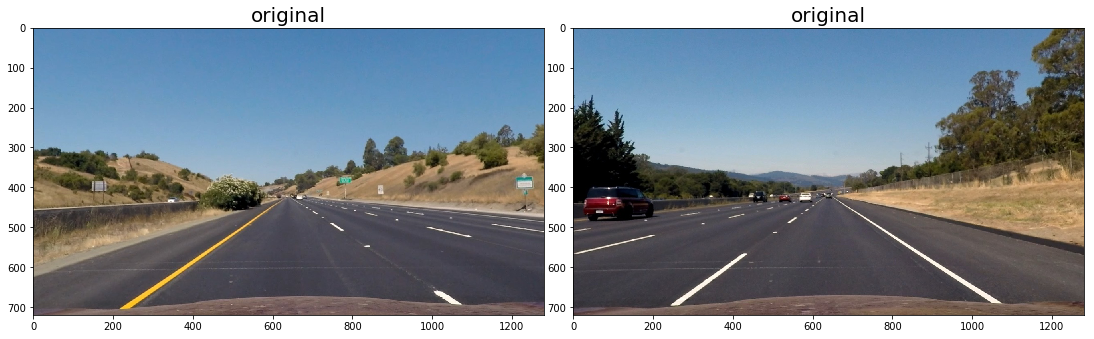

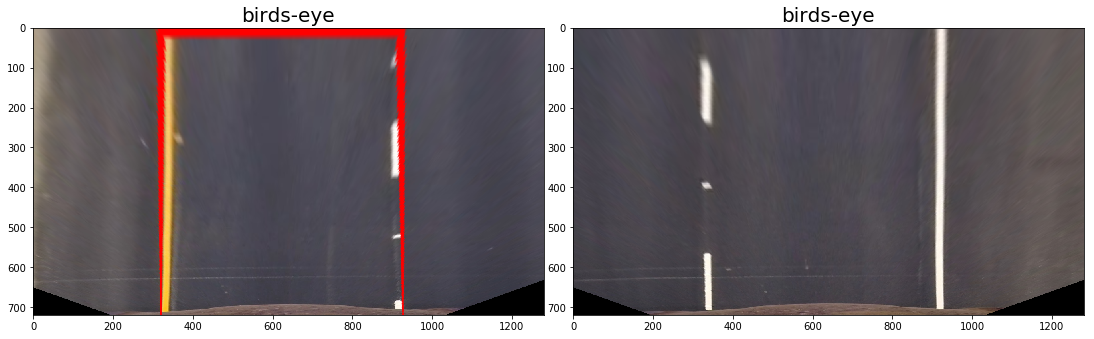

In [10]:
img_size = (img_poly[0][1], img_poly[0][0])
images_straight_unwarp = [change_persepctive(image, M) for image in (img_poly, images_undis_straight[1])]

display_images(images_undis_straight, title=['original', 'original'])
display_images(images_straight_unwarp, title=['birds-eye', 'birds-eye'])

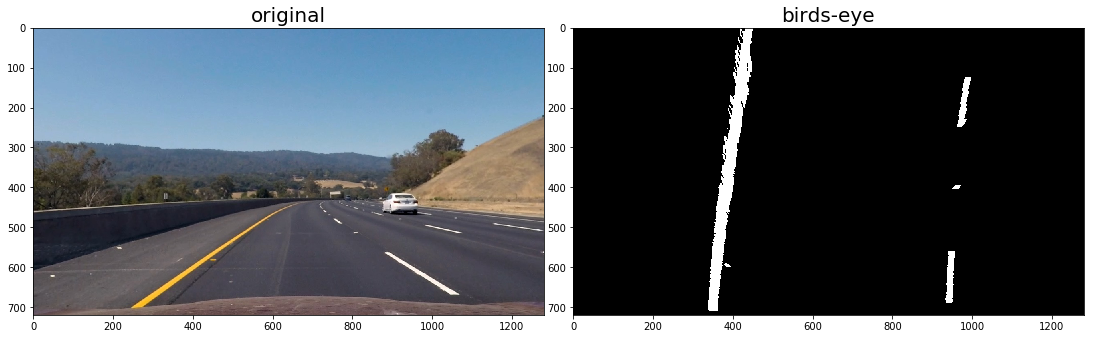

In [11]:
images_unwarp = [change_persepctive(image, M) for image in images_thresh]

display_images([images_undis[2], images_unwarp[2]], title=['original', 'birds-eye'])

## 4. Fitting lane lines

In the next step we have to decide which pixels of the binary image are actual lane line pixel. The algorithm we employ makes use of the observation that lane lines should have a higher intensity than background object. If we create a histogram of the entire image along the x-axis the two lane lines are assumed to have the highest peaks. The location of of these peaks give a first indication of the location of the actual lane lines.  

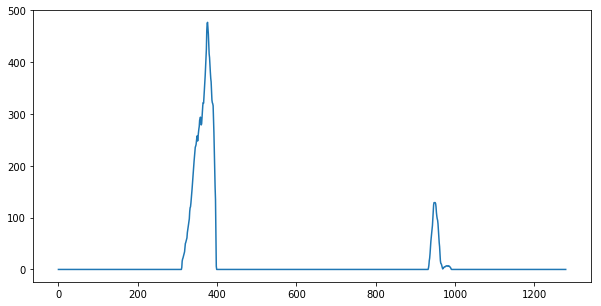

In [12]:
fig = plt.figure(figsize = (10, 5))
histogram = np.sum(images_unwarp[0], axis=0)
plt.plot(histogram);

The algorithm to decide which pixels are lane line pixels has the following steps:
* divide image along x-axis in two regions (for left and right lane line)
* for each region create histogram with appropriate binning and assume location of peaks correspond approximately to location of lane lines
* divide image along y-axis in nine regions
* for first region choose a 200 pixel wide window centered at these approximate lane line locations
* all pixels in both windows are assumed to be lane line pixels
* compute more precise location of lane lines by computing the mean position of all pixels within each window
* use this updated lane line location as starting point for the next one of the nine windows
* iterate over all nine windows repeating the previous steps
* updating the approximate lane line location is only performed if the 200 pixel wide window contains at least 50 non-zero pixels 
    
After determining the lane line pixels they are fitted with a second order polynom of the form
$$lane(y) = a\cdot y^2 + b\cdot y + c.$$
The polynom is written in dependence of $y$ due to the small changes in $x$.

In [13]:
def fit_lane_lines(binary_unwarped):
    """Fit lane line pixels with a second order polynom and return result.
    
    Return None if fit failed.
    
    Args:
        binary_unwarped -- A binary image transformed to birds-eye view 
    Returns:
        left_fit  -- coefficients of polynom fitting left lane line
        right_fit -- coefficients of polynom fitting left lane line
        out_img   -- image where left and right lane line points are highlighted in red and green
                   respectively
    """
    # stacks three binary_unwarped images on top of eachother
    # allows to draw e.g. a colored rectangle
    out_img = np.dstack((binary_unwarped, binary_unwarped, binary_unwarped))

    # find midpoint between left and right halves of image
    midpoint = binary_unwarped.shape[1]//2

    # midpoints and margins of the regions where we look for lane line pixels
    leftx_base = None
    rightx_base = None
    margin = 100 

    # number of windows 
    nwindows = 9
    # window_height (in y direction), note that window_width = 2*margin)
    window_height = binary_unwarped.shape[0]//nwindows

    # identify the x and y indices of all non-zero pixels in the whole image
    # python trick: why interchange x and y?
    nonzerox = binary_unwarped.nonzero()[1]
    nonzeroy = binary_unwarped.nonzero()[0]
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # y coordinates of the sliding window
        win_y_high = binary_unwarped.shape[0] - window*window_height
        win_y_low = win_y_high - window_height

        # in case of first window: search for maximum peaks in right and left halves of the image
        # and use these points as center points of each window
        if window==0:
            histogram = np.sum(binary_unwarped, axis=0)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = midpoint + np.argmax(histogram[midpoint:])
                
        # x coordinates of the left and right window 
        win_xleft_low = leftx_base - margin
        win_xleft_high = leftx_base + margin
        win_xright_low = rightx_base - margin
        win_xright_high = rightx_base + margin    
    
        # draw window regions on image for visualization
        #left lane line
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        # right lane line
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
    
        # all points within in the windows are considered as lane line pixels:
        # get the x, y-indices of these pixels (note that e.g. the first entry of nonzerox and nonzeroy
        # refer to the same point, false is interpreted as 0)
        # left lane line
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        # right lane line
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]    
    
        # append indices to lists (python trick)
        # note that these indices refer to the index of the lane line pixels
        # in nonzerox and nonzeroy arrays
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # udate leftx_base and rightx_base for next window
        minpix = 50
        if len(good_left_inds) > minpix:
            leftx_base = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_base = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if (leftx.size==0) or (lefty.size==0) or (rightx.size==0) or (righty.size==0):
       return None
    
    # Fit a second order polynomial to each line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # draw imageout_img
    ploty = np.linspace(0, binary_unwarped.shape[0]-1, binary_unwarped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]   
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img


def points_for_drawing(image, left_fit, right_fit):
    """Generate lane line points for plotting.
    
    Args:
        image     -- image to draw lane lines on 
        left_fit  -- coefficients of polynom fitting left lane line
        right_fit --
    Returns:
        left_fitx  -- x coordinates of points of left lane line (for plotting)
        right_fitx -- x coordinates of points of right lane line (for plotting)
        ploty      -- y coordinates of lane line pixls (for plotting)    
    """
    ydim = image.shape[0]
    ploty = np.linspace(0, ydim-1, ydim)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    return left_fitx, right_fitx, ploty


fit_results = [fit_lane_lines(image) for image in images_unwarp]

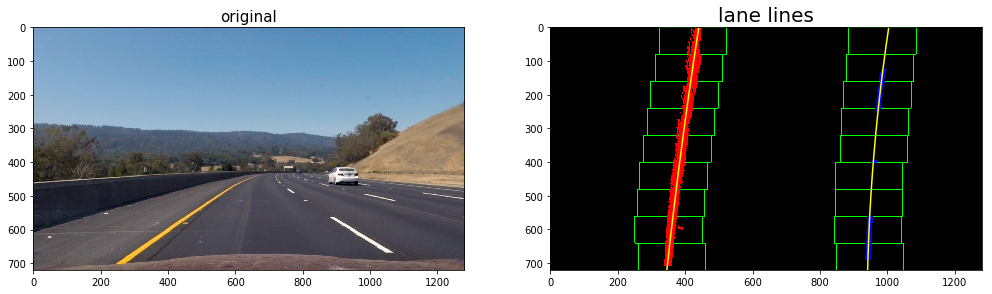

In [14]:
left_fit, right_fit, out_img = fit_results[2]
left_fitx, right_fitx, ploty = points_for_drawing(out_img, left_fit, right_fit)

    
fig = plt.figure(figsize = (17, 10))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("original", fontsize=15)
plt.imshow(images_undis[2])
ax = fig.add_subplot(1, 2, 2)
ax.set_title("lane lines", fontsize=15)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.title("lane lines", fontsize=20)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imshow(out_img);

## 5. Inverse Transform

After determining the coefficients of the second order polynom describing the lane lines we have to draw it on the original image. First we draw the lane lines on a blank image. At this point the perspective is still in *birds-eye view*. Afterward we apply the inverse perspective transformation to transform the perspective of the image back to the one of the original image. Then we are able to combine the resulting image with the original image. Instead of highlighting the lane lines in red as in the first project we use a green area to highlight the area where the road is located.

In [15]:
def draw_lines(undist, unwarped, Minv, left_fitx, right_fitx, ploty):
    """Draw lane lines on original image.
    
    Args:
        undist     -- original image
        unwarped   -- binary warped image
        Minv       -- transform matrix to transform birds-eye view to original image
        left_fitx  -- x-coordinates of left lane line
        right_fitx -- x-coordinates of right lane line
        ploty      -- y-coordinates of lane line
    Return:
        Original image with lane lines drawn on.
    """
    
    # create mage to draw lines on
    unwarped = np.zeros_like(unwarped).astype(np.uint8)
    color_unwarp = np.dstack((unwarped, unwarped, unwarped))

    # transform x and y points to appropriate format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # draw the lane on the blank image
    cv2.fillPoly(color_unwarp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using Minv
    newwarp = cv2.warpPerspective(color_unwarp, Minv, (undist.shape[1], undist.shape[0])) 
    # combine new image with original one
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

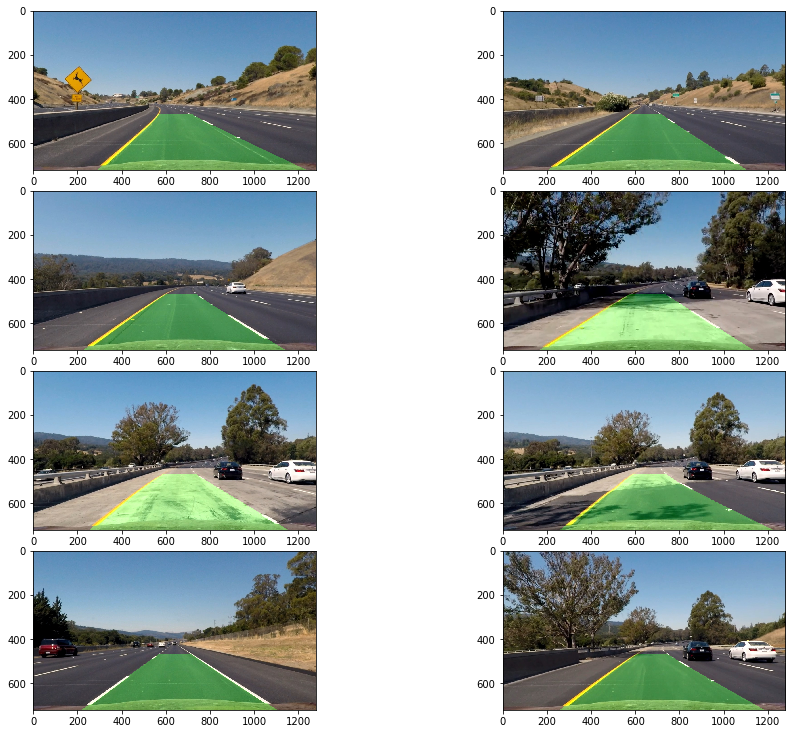

In [16]:
final_image = []
for idx in range(0, len(fit_results)):
    left_fit, right_fit, out_img  = fit_results[idx]
    left_fitx, right_fitx, ploty = points_for_drawing(out_img, left_fit, right_fit)
    undis = images_undis[idx]
    unwarped = images_unwarp[idx]
    final_image.append(draw_lines(undis, unwarped, Minv, left_fitx, right_fitx, ploty))
    
display_images(final_image)

## 6. Radius of curvature and center offset

For determining an appropriate steering angle the car needs to know the offset from the center of the lane line and the curvature of the lane line. These two quantities can be determined in a straightforward way from the fit results. The radius of the curvature is given as follows:

$$R_{curv}(y) = \frac{(1 + (2Ay + B)^2)^{3/2}}{|2A|}.$$

$A$ and $B$ are the second and first order coefficients of the polynom respectively. The offset of the center of the car from the center of the lane line can be computed with

$$d_{off} = x_{left} + \frac{x_{left} - x_{right}}{2} - x_{center}.$$

$x_{center}$ is the center of the car (assumed to be the center of the image i.e. the camera is mounted in the center of the car). $x_{left} + \frac{x_{left} - x_{right}}{2}$ is the center of the lane line. $d_{off}$ is negative if the car is too far on the right with respect to the center of the lane line and positive otherwise.

In [17]:
def radius_of_curvature(fit_res, y_eval):
    """Computes radius of curvature in meters.
    
    Args:
        fit_res -- coefficients of polynom
        y_eval  -- y-position at which curvature is evaluated
    """
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700
    A = fit_res[0]*xm_per_pix/(ym_per_pix**2)
    B = fit_res[1]*xm_per_pix/ym_per_pix  
    return round(((1 + (2*A*y_eval*ym_per_pix + B)**2)**1.5) / np.absolute(2*A), 3)

def offset_center(img, left_fit, right_fit):
    """Computes offset from center of lane (center of car = center of image).
    
    Positive: car is on the left of lane center
    Negative: car is on the right of lane center
    """
    xm_per_pix = 3.7/700
    height, width = img.shape[:2]
    x_center = width // 2
    left_fitx = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_fitx = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2] 
    center_lane = (right_fitx - left_fitx) / 2 + left_fitx
    return round((center_lane - x_center)*xm_per_pix, 2)
    

left_fit, right_fit, out_img = fit_results[0]
print("left lane curvature: ", radius_of_curvature(left_fit,  720), "m")
print("right lane curvature:", radius_of_curvature(right_fit, 720), "m")
print("offset from lane center:", offset_center(out_img, left_fit, right_fit), "m")

left lane curvature:  1495.728 m
right lane curvature: 1385.127 m
offset from lane center: 0.29 m


## 7. Full Pipeline

In order to process a video (i.e. a stream of images) we implement a class which executes the full pipline
* undistort camera image
* apply thresholds to create a binary image where pixels which are not part of the lane line are suppressed
* change perspective to birds-eye view
* fit lane lines with a second order polynom
* check if fit was successful and is not an outlier
* draw lane lines on blank image
* transform  perspective of image with lane line to original perspective and combine result with original image
* add curvature and offset information to image.

In addition we implemented an averaging of detected lane lines to prevent it from jumping around from image to image. Our algorithm considers the last nine successfully fitted lane line and averages them with the fit result of the current image. The averaging is done for each of the three coefficients of the second order polynom (e.g. all second order coefficients are averaged). This procedure helps to reduce the jumping of lane lines significantly. It is not advised to consider more than previous ten successful fits for averaging because the algorithms wouldn't be able to follow changes in lane line curvature appropriately. 

Sometimes no valid fit was possible. In this case the corresponding image is disgarded and the averaged lane lines of the previous ten successful fits are plotted. These lane lines are identical to the one plotted on the previous video frame.

In other cases a valid fit was possible but the result is not meaningful. This can happen if besides the actual lane lines background pixels are present in the binary image. The algorithms tries to fit these pixels as well, which might result a unreasonable lines which are strongly curved. This would influence not only the current image but also at least the ten next frames. The best way to prevent this effect is to analyse the root cause and improve the *threshold*-function such that pixels that are not part of the lane line are suppressed sufficiently. A complementary approach is to conduct an outlier detection to filter fits that exhibit unreasonable coefficients. In our implementation each fit result is checked for unreasonable large coefficients of the qudratic term of the polynom (which determines the curvature of the line). In addition we check if the right and left lane line are curved in the same direction and if the curvature doesn't deviate too much from the average of the previous ten successful fits. The latter two points are only considered if the lane line is not straight.

If the current fit is an outlier it is disgarded and the average of the previous fits is plotted on the current image (same treatment as for the not successful fit). 

In [18]:
import collections

class FindLaneLines:
    def __init__(self, mtx, dist, M, Minv):
        # container to save previously determined lane lines
        self.memory = 10
        self.left = collections.deque(maxlen=self.memory)
        self.right = collections.deque(maxlen=self.memory)
        # average
        self.left_avg = None
        self.right_avg = None
        # matrices for perspective transformation, distortion coefficients and undistort matrix
        self.mtx = mtx
        self.dist = dist
        self.M = M
        self.Minv = Minv
        
    def process_image(self, image):
        """Process image with pipeline and return image with detected lane lines drawn on it.""" 
        image_orig = np.copy(image)
        # undistort image
        undist = undistort(image_orig, self.mtx, self.dist) 
        # apply thresholds
        thresh = threshold(undist)
        # warp to birds-eye view
        warped = change_persepctive(thresh, self.M)
        # fit lane lines
        result = fit_lane_lines(warped)
        
        # if fit not successful return previous lane line
        if result is None:
            left_fitx, right_fitx, ploty = points_for_drawing(image, self.left_avg, self.right_avg)
            image = draw_lines(undist, warped, self.Minv, left_fitx, right_fitx, ploty)
            return image   
        left_fit, right_fit, out_img = result
         
        def outlier_radius(curr_left, avg_left, curr_right, avg_right):
            """Check if current lane line is outlier."""
            # in case image is first frame of video
            if avg_left is None:
                return True
            # filter out lines with strong curvature
            cond1 = np.abs(curr_left[0]) < 0.001
            cond2 = np.abs(curr_right[0]) < 0.001
            # do not apply filter if lines are straight
            cond3 = True
            if np.abs(curr_left[0])>0.0002 or np.abs(curr_right[0])>0.0002:   
                # lane lines should be curved in opposite directions
                cond4 = np.sign(curr_left[0]*curr_right[0])==1
                # current lane lines should not deviate too much from average of previous lane lines 
                cond5 = np.abs(avg_left[0]-curr_left[0]) < 2*curr_left[0]
                cond6 = np.abs(avg_left[0]-curr_left[0]) < 2*curr_left[0]
                cond3 = (not cond4) and (not cond5) and (not cond6)            
            return cond1 and cond2 and cond3
                        
        # if lane line of current image is no outlier update left_avg and right_avg values
        # otherwise return previous lane line
        no_outlier = outlier_radius(left_fit, self.left_avg, right_fit, self.right_avg)
        if no_outlier: 
            self.left.append(left_fit)
            self.right.append(right_fit)
            # compute new average (smoothing)
            self.left_avg = np.mean(self.left, axis=0)
            self.right_avg = np.mean(self.right, axis=0)
           
        # draw lane lines on image
        left_fitx, right_fitx, ploty = points_for_drawing(image, self.left_avg, self.right_avg)
        image = draw_lines(undist, warped, self.Minv, left_fitx, right_fitx, ploty)
        
        # add text to image about center offset and curvature to image
        r_avg_left = radius_of_curvature(self.left_avg, np.max(ploty)) 
        r_avg_right = radius_of_curvature(self.right_avg, np.max(ploty)) 
        offset = offset_center(img, left_fit, right_fit)
        cv2.putText(image, 'curvature (left) : ' + str(round(r_avg_left, 2)) + 'm',  (80, 90),  cv2.FONT_HERSHEY_SIMPLEX, 
                    1.3, (255,255,255), thickness=2)
        cv2.putText(image, 'curvature (right): ' + str(round(r_avg_right, 2)) + 'm', (80, 150), cv2.FONT_HERSHEY_SIMPLEX, 
                    1.3, (255,255,255), thickness=2) 
        cv2.putText(image, 'offset: ' + str(offset) + 'm', (80, 200), cv2.FONT_HERSHEY_SIMPLEX, 
                    1.3, (255,255,255), thickness=2)  
        return image
    

Let's test the full pipline on the six test images.

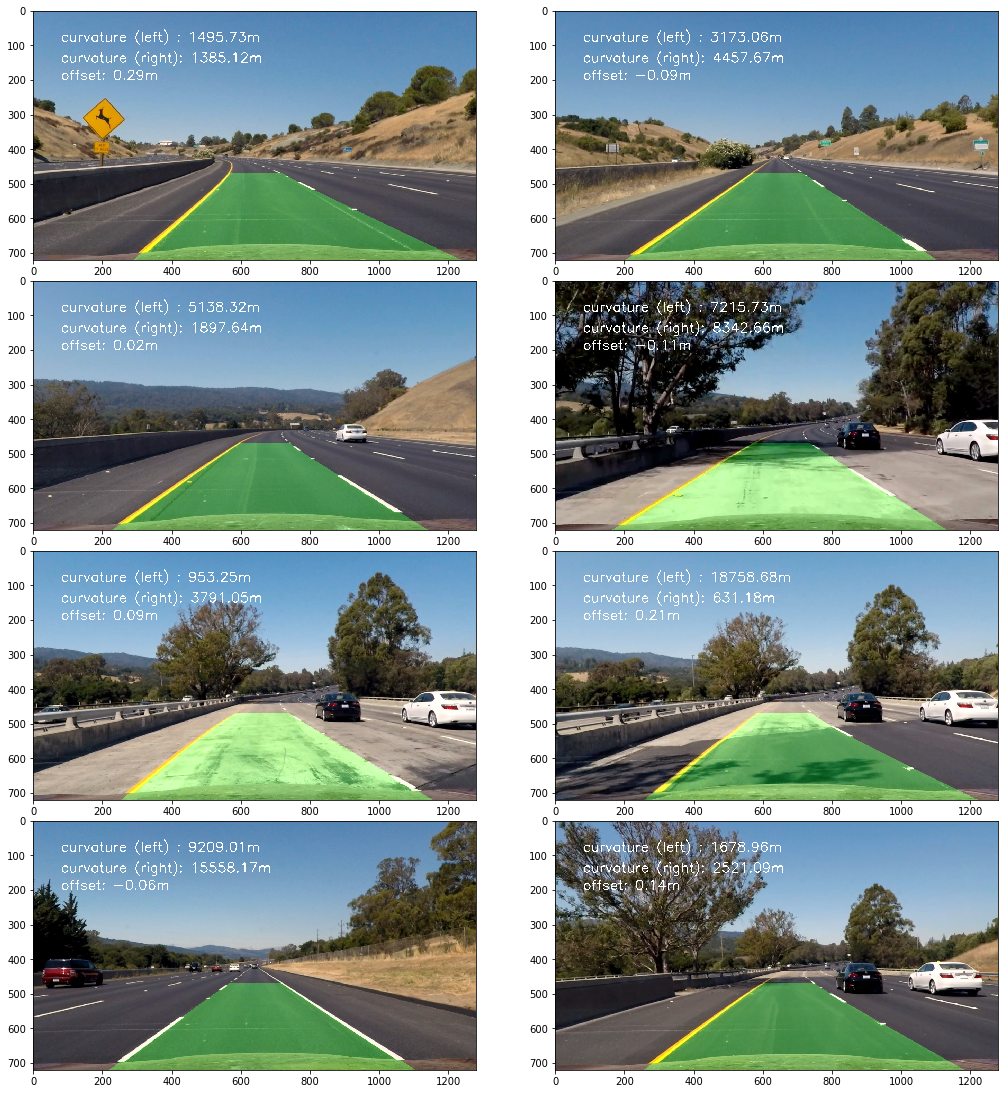

In [19]:
pic = []
for img in images_orig:
    detector = FindLaneLines(mtx, dist, M, Minv)
    pic.append(detector.process_image(img))
    
display_images(pic, figsize = (15, 15))

## 8. Video stream

As a last step we have to apply the full pipeline to the video stream. The video is processed in a couple of minutes, although we don't make use of the more efficient method described in the course to find lane lines (based on the fit results of the previous frame to guide the search in the current frame). 

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os


def process_video(video_input, video_output):
    detector = FindLaneLines(mtx, dist, M, Minv)

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process_image)
    processed.write_videofile(os.path.join('test_videos_output', video_output), audio=False)

In [22]:
%time process_video('project_video.mp4', 'project_video.mp4') 

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



 12%|█▏        | 154/1261 [00:28<03:14,  5.70it/s]


 24%|██▍       | 305/1261 [00:57<03:17,  4.84it/s]


 36%|███▌      | 456/1261 [01:31<01:57,  6.83it/s]


 48%|████▊     | 608/1261 [02:00<01:50,  5.93it/s]


 61%|██████    | 772/1261 [02:25<01:31,  5.34it/s]


 74%|███████▍  | 930/1261 [02:50<00:48,  6.82it/s]


 86%|████████▌ | 1080/1261 [03:14<00:32,  5.59it/s]


 98%|█████████▊| 1242/1261 [03:38<00:03,  5.89it/s]


100%|█████████▉| 1260/1261 [03:41<00:00,  7.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 9min 55s, sys: 13.5 s, total: 10min 9s
Wall time: 3min 42s


Essentially all lane lines of the video *project_video.mp4* are detected correctly by the algorithm. The algorithm is able to handle variations in brightness as well as shadows on the road. In particular there is no catastrophic failure of the pipline which whould cause the car to leave its current lane and potentially crash. 

The resulting video was uploaded on youtube (see link below). The region of the image identified by the algorithm as actual road (bordered by the detected lane lines) is highlighted in green. 

In [23]:
%time process_video('challenge_video.mp4', 'challenge_video.mp4') 

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4



 40%|████      | 194/485 [00:25<00:40,  7.17it/s]


 77%|███████▋  | 374/485 [00:51<00:13,  8.25it/s]


100%|██████████| 485/485 [01:06<00:00,  7.25it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 3min 25s, sys: 4.04 s, total: 3min 29s
Wall time: 1min 8s


In contrast to video *project_video.mp4* the algorithm has problems to detect lane lines in video *challenge_video.mp4* reliably (but still there wouldn't be any catastrophic failure). In particular the left lane line - which is close to a shadow - is sometimes described by a polynom being curved in the direction of the shadow. Clearly, additional suppression of background pixels is needed here. 

* [project video](https://youtu.be/psQJ1KA-wtk)
* [challenge video](https://www.youtube.com/watch?v=zMv0oHytInE)

## 9. Conclusions

The objective of the  project was met. We developed an algorithm which is able to detect lane lines in video streams using methods like camera calibration, color thresholding, region selection, perspective transformation and outlier detection. The algorithm worked satisfactory for the video *project_video.mp4* but has some problems with video *challenge_video.mp4* due to shadows on the left-hand side of the road. Possible improvements are:
* better suppression of background pixels
* use more robust fit method (least-square fit is sensitive to outliers)